# CMS bTagging Exercise

The aim of the exercise is to prepare a ML tool which is able to discriminate as much as possible between jets coming from the hadronization of light quarks and gluons, and b quarks; jets from c quarks being an intermediate case.

In this exercise you will
- explore the content of a simulate dataset from CMS containing per jet features to be used t|o test the discrimination
- try to plot quantities and understand what can be used
- train various (?) network type in order to perform the job, and test their abilities; this can be done at various complexity levels

#### The exercise is largely (completely?) based on the work by L.Giannini (UCSD). See the ML_INFN knowledge basis ([here](https://confluence.infn.it/display/MLINFN/1.+Btagging+in+CMS))

First of all, you need to access the data. We provide 2 files in numpy format; in most use cases you will use only the first splitting the samples in train and test. the second can be used in more complex cases.
In order to get the data files, you can use Linux Shell commands (**"cp", "wget", ...**) to put the input files in a given place. Here, we put the two files (**"test93_0_20000.npz" and "test93_20000_40000.npz"**) in a local directory, from a public web server.

In order not to repeat the download N times, we check if the file is alredy available.

The "! command" syntax in Jupyter executes a shell command, so we can use it to download the file and check later if it is ok. It should be ~ 40 MB. If it is less than that, you should remove it and retry (**"!rm -f test93_0_20000.npz"**).


In [1]:
# next line can be needed if you get a strange error when declaring an LSTM. After uncommenting it, you need to restart the otebook from scratch
#
#!pip install -U numpy==1.19
import os
if not os.path.isfile('test93_0_20000.npz'):
 !wget http://www.pi.infn.it/~boccali/test93_0_20000.npz

--2021-05-25 08:35:43--  http://www.pi.infn.it/~boccali/test93_0_20000.npz
Resolving www.pi.infn.it (www.pi.infn.it)... 212.189.152.86
Connecting to www.pi.infn.it (www.pi.infn.it)|212.189.152.86|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.pi.infn.it/~boccali/test93_0_20000.npz [following]
--2021-05-25 08:35:43--  https://www.pi.infn.it/~boccali/test93_0_20000.npz
Connecting to www.pi.infn.it (www.pi.infn.it)|212.189.152.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41920506 (40M)
Saving to: ‘test93_0_20000.npz’

test93_0_20000.npz  100%[===================>]  39.98M  58.7MB/s    in 0.7s    

2021-05-25 08:35:43 (58.7 MB/s) - ‘test93_0_20000.npz’ saved [41920506/41920506]



In [2]:
!ls -l test*

-rw-r--r-- 1 root root 41920506 Mar 30 13:51 test93_0_20000.npz


The numpy file contains 2 arrays

In [3]:
import numpy

f=numpy.load("test93_0_20000.npz")

print (f.files)

['arr_0', 'arr_1']


In the first part of this exercise you will use only the first one (**"arr_0"**); we want to see its shape. Remember that a numpy array has 1 line per entry, and the columns are the various features someone (CMS in this case) has prepared per entry.
In particular, an "entry" here is a single hadronic jet.

In [4]:
f["arr_0"].shape

(20000, 52)

So the file contains 20000 jets, and for each of them 52 "features". The file does NOT contain an explanation of what they are, which needs to be provided externally. In this particular case, these are the 52 numbers:

## Ntuple content

### Jet kinematics
0 - **"jet_pt"** : the transverse momentum of the jet

1 - **"jet_eta"** : the radipity of the jet (see https://en.wikipedia.org/wiki/Pseudorapidity)

### Jet constituents in terms of tracks and vertices
2 - **"nCpfcand"** : number of charged object candidates in the CMS particle Flow reconstruction

3 - **"nNpfcand"** : number of neutral object candidates in the CMS particle Flow reconstruction

4 - **"nsv"** : number of secondary vertices in the jet

5 - **"npv"** : number of primary vertices in the event

6 - **"n_seeds"** : number of tracks associated to the jet

### b tagging discriminataing variables

7 - **"TagVarCSV_trackSumJetEtRatio** : one standard btag discriminator for CSV algorithm, see *https://cds.cern.ch/record/2298594/files/arXiv:1712.07158.pdf* 

8 - **"TagVarCSV_trackSumJetDeltaR"** : as above

9 - **"TagVarCSV_vertexCategory"** : as above

10 - **"TagVarCSV_trackSip2dValAboveCharm"** : as above

11 - **"TagVarCSV_trackSip2dSigAboveCharm"** : as above

12 - **"TagVarCSV_trackSip3dValAboveCharm"** : as above

13 - **"TagVarCSV_trackSip3dSigAboveCharm"** : as above

14 - **"TagVarCSV_jetNSelectedTracks"** : as above

15 - **"TagVarCSV_jetNTracksEtaRel"** : as above


### other kinematics variables of the jet
16 - **"jet_corr_pt"** : jet corrected Pt (corrected for known miscalibrations)

17 - **"jet_phi"** :  jet phi angle

18 - **"jet_mass"** : jet mass, omputed from its constituents

### detailed Monte Carlo truth of the event (categories are NOT exclusive!)
19 - **"isB"** : is the jet coming from the decay of a B hadron?

20 - **"isGBB"** : is the jet coming from the a gluon splitting to BB?

21 - **"isBB"** : is the jet coming from a BB pair (not from gluon splitting)?

22 - **"isLeptonicB"** : is the jet coming from a leptonic decay of a B hadron?

23 - **"isLeptonicB_C"** : is the jet coming from a leptonic decay of a D hadron coming from a B hadron?

24 - **"isC"** : is the jet coming from a charm hadron decay?

25 - **"isGCC"** : is the jet coming from the a gluon splitting to CC?

26 - **"isCC"** : is the jet coming from a CC pair (not from gluon splitting)?

27 - **"isUD"** : is the jet coming from a Up or Down hadron(no heavier quarks)?

28 - **"isS"** : is the jet coming from a Strange hadron(no heavier quarks)?

29 - **"isG"** : is the jet coming from a a gluon?

30 - **"isUndefined"** : special case in which there was no  clear identification

31 - **"isPhysB"** : same as above, with an alternative definition

32 - **"isPhysGBB"** : same as above, with an alternative definition

33 - **"isPhysBB"** : same as above, with an alternative definition

34 - **"isPhysLeptonicB"** : same as above, with an alternative definition

35 - **"isPhysLeptonicB_C"** : same as above, with an alternative definition

36 - **"isPhysC"** : same as above, with an alternative definition

37 - **"isPhysGCC"** : same as above, with an alternative definition

38 - **"isPhysCC"** : same as above, with an alternative definition

39 - **"isPhysUD"** : same as above, with an alternative definition

40 - **"isPhysS"** : same as above, with an alternative definition

41 - **"isPhysG"** : same as above, with an alternative definition

42 - **"isPhysUndefined"** : same as above, with an alternative definition

### premade combinations for definig categories (6 of them)

43 - **"isB*1"** : as above

44 - **"isBB+isGBB"** : from B or GBB

45 - **"isLeptonicB+isLeptonicB_C"** : there is a lepton from the B decay (either direct or via a Charm)

46 - **"isC+isGCC+isCC"** : there is a Charm in the jet

47 - **"isUD+isS"** : it is light

48 - **"isG*1"** : from gluon

49 - **"isUndefined*1"** : see above

### truth as integer (used in the notebook)

50 - **"5x(isB+isBB+isGBB+isLeptonicB+isLeptonicB_C)+4x(isC+isGCC+isCC)+1x(isUD+isS)+21xisG+0xisUndefined"** : expected to be 5 if there is a B, for if it is a C, 1 if it il light, 21 if from gluon

### alternative definition
51 - **"5x(isPhysB+isPhysBB+isPhysGBB+isPhysLeptonicB+isPhysLeptonicB_C)+4x(isPhysC+isPhysGCC+isPhysCC)+1x(isPhysUD+isPhysS)+21xisPhysG+0xisPhysUndefined"** : the alternative definition

We are not going to use all the variables (which ones can be your choice).
Let's start by preparing a standard way to plot quantities, as a function of the True origin of the jet.

We can use, fro example, "arr_0[-2]" (which is entry 50) as a definition of the origin:

it basically does  "5 \*(any source of b quarks) + 4 \*(any source of c quarks)+ 1 \*(any source of light quarks) + 20\*(any source of gluons)".

In the case of gluons, there is always also at least a light quark (so we expect 21, not 20). Consider this a quirk of the way CMS is labelling.

Let's scan them


MC Truth [21. 21. 21. ... 21. 21.  4.]


(array([ 4339.,     0.,     0.,  2032.,  2377.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0., 11252.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21.]),
 <BarContainer object of 20 artists>)

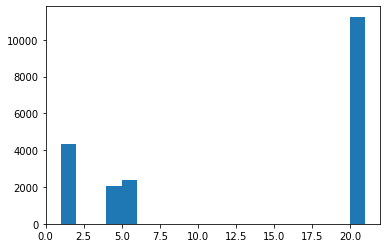

In [5]:
from matplotlib import pyplot
jetvars=f['arr_0']
print ("MC Truth",jetvars[:,-2])
pyplot.hist(jetvars[:,-2],bins=20)

You see there are many jets from gluons (20+), many from light quarks (1), and some from charm (4) and bottom (5) quarks

Let's do some better plots, for example coloring and putting labels

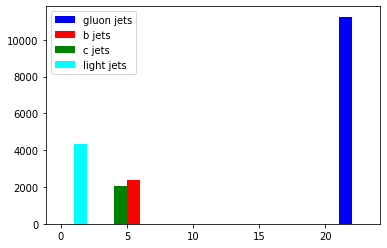

In [6]:
bins=range(0,24)
pyplot.hist(jetvars[jetvars[:,-2]==21][:,-2], color="blue", bins=bins, label="gluon jets")
pyplot.hist(jetvars[jetvars[:,-2]==5][:,-2], color="red", bins=bins, label="b jets")
pyplot.hist(jetvars[jetvars[:,-2]==4][:,-2], color="green", bins=bins, label="c jets")
pyplot.hist(jetvars[jetvars[:,-2]==1][:,-2], color="cyan", bins=bins, label="light jets")
pyplot.legend()

Now, we would like to plot some quantities for the 4 categories, and see that (if!) they have discrimination power. In order to do this, we need some "tools" to proper visualize it.

We create a plotter function, which we can use to plot any of the 52 features by class

In [7]:
# Plotting function - you may use it or not
# maybe you just want to check what it's doing

def plotter_wbins(  data, categories, labels, colors, name="name___", log=False, mybins=None, density=False):

    mean=numpy.mean(data)
    stdev=numpy.std(data)
    lenbin=stdev/(len(data)**0.5)    
    
    if (lenbin==0) :
        return
    
    binning=numpy.arange(mean-2*stdev, mean+2*stdev, lenbin*10)    
    if mybins is not None:
      binning=mybins

    pyplot.clf()
    
    for i in range(len(categories)):
        cat=categories[i]
        color=colors[i]
        label=labels[i]
        
        pyplot.hist(data[cat], color=color, label=label, histtype='step', bins=binning, log=log, density=density)

    pyplot.legend()
    pyplot.xlabel(name)
    pyplot.ylabel("entries")
    pyplot.savefig(name+".png")
    # Prepare function inputs

isB=jetvars[:,-2]==5
isC=jetvars[:,-2]==4
isL=jetvars[:,-2]==1
isG=jetvars[:,-2]==21

categories=[isB, isC, isL, isG]
labels=["b jets","c jets","light jets","gluon jets"]
colors=["red","green","cyan","blue"]


With this, we can plot a feature. For example, we plot arr_0[0] (which is the jet_pt)

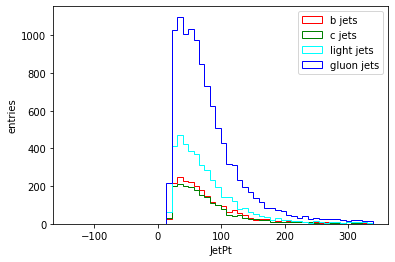

In [8]:
plotter_wbins(jetvars[:,0], categories, labels, colors, name="JetPt" )

You can try a few features, and see if you consider the difference enogh evident to try and use it in a discriminator. 
The features from 7 to 15 are the best. Do you understand why? is this expected?

In some cases, plotting in log y scale helps

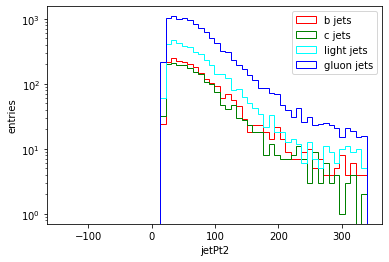

In [9]:
plotter_wbins(jetvars[:,0], categories, labels, colors, name="jetPt"+str(2), log=True)

Another useful way to look into discrimitating features, is to plot their "density", which means single histogram areas are nomalized to 1. See that in the previous function definition, you can can pass a density parmeter. Try it!

You can have a look at, for example, the first ~15 features and identify those which seem more promising in your case.

When you report in the afternoon session, please shoe a few of them.


A better way to understand the discriminating power of a feature is by plotting a ROC (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) curve using that.

What we need to do, is to put increasing cuts on that variable, which select some B and some "not B" events. By changin the cut, one can construct a plot in the plane "B efficiency" vs "Non B efficiency". Clearly a feature is better at selecting B events if it obtains an higher B efficiency at a fixed value of non B efficiency, or alternatively a lower non B efficiency at a fixed B efficiency.  

There are many ways to quantify if a ROC is good; one of them is called Area Under the Curve (AUC, https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve).

ADDDDD


Let's prepare a tool which does that, with scikit-learn which already has a ROC and AUC feature.
Let's plot it for feature #11, which should have discriminating power



In [10]:
from sklearn.metrics import roc_curve, auc


How does it work?  From the documentation: [here](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) says **roc_curve(y_true, y_score, ...)**

We need to pass 
   * y_true: the true labels (in our case the jet category) 
   * y_score: can either be probability estimates of the positive class (so a structure identical in structure to the previous one, but with probabilities instead of 0 and 1s), confidence values, or non-thresholded measure of decisions - in our case it is the latter: the variable on which to apply different cuts to scane the parametner space.

The tool will prepare
   * false positive rate: our y axes
   * true positive rate : our x axes
   * the thresholds

We can create out of it a function which prepares the categories and feed them

In [11]:
def plot_roc_curve(isB,isC,isL, isG,variable):

    #do you understand what it does? try and print it to understand ... for example, which is the length of isB[isB+isC]? what does it mean?
    isBvsC = isB[isB+isC]
    isBvsUSDG = isB[isB+isL+isG]

    # B vs ALL roc curve

    fpr, tpr, threshold = roc_curve(isB,variable)
    auc1 = auc(fpr, tpr)

    # B vs c

    fpr2, tpr2, threshold = roc_curve(isBvsC,variable[isB+isC])
    auc2 = auc(fpr2, tpr2)

    # B vs light/gluon

    fpr3, tpr3, threshold = roc_curve(isBvsUSDG, variable[isB+isL+isG])
    auc3 = auc(fpr3, tpr3)

    # print AUC

    print ("AUCs", auc1, auc2, auc3)
    
    return tpr,fpr,tpr2,fpr2,tpr3,fpr3


In [12]:
print(len (isB))
print(len(isB[isB+isC]))

20000
4409


0.6702144535131177 0.6551470125447613 0.6721782172260098


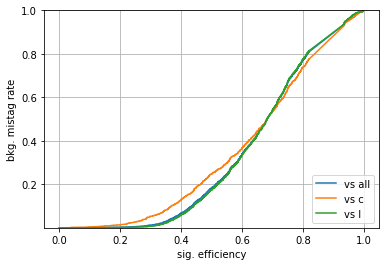

In [13]:
tpr,fpr,tpr2,fpr2,tpr3,fpr3 = plot_roc_curve(isB,isC,isL, isG,jetvars[:,11])

pyplot.plot(tpr,fpr,label="vs all")
pyplot.plot(tpr2,fpr2,label="vs c")
pyplot.plot(tpr3,fpr3,label="vs l")
pyplot.xlabel("sig. efficiency")
pyplot.ylabel("bkg. mistag rate")
pyplot.ylim(0.000001,1)
pyplot.grid(True)
pyplot.legend(loc='lower right')


Since we expect that the y axes (non B efficiency) should be small, it is customary to plot it in log scale

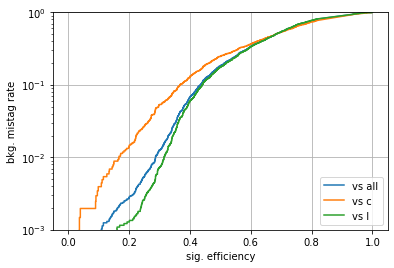

In [14]:
pyplot.plot(tpr,fpr,label="vs all")
pyplot.plot(tpr2,fpr2,label="vs c")
pyplot.plot(tpr3,fpr3,label="vs l")
pyplot.semilogy()
pyplot.xlabel("sig. efficiency")
pyplot.ylabel("bkg. mistag rate")
pyplot.ylim(0.001,1)
pyplot.grid(True)
pyplot.legend(loc='lower right')


Can you explain what it means? For example, what does the green point at x=0.2, y~0.0015 indicate? What do you expect from a GOOD algorithm wrt a BAD algorithm?

Repeat the exercise with different input features. You will find that some of them have nearly no discriminant power. Can you find one? Can you explain if that is expected or not?

### answer: feature 17 is the jet_phi, you expect no distinction between anything (it is just a flat distribuition). and indeed you get a ROC which is diagonal in the two efficiencies

Let's build a Dense Neural Network (DNN) to generate a new, more powerful disciminator

You can choose which features to use, among these with a larg(ish) discriminating power. You can chose your list, but:

- does it make sense to use any feature above #18? Why?
- from what you know about ML, is it important to choose only good ones? What happens if you include one with scarce / absent discriminating power?

So this is the plan here: 
- define a subset of the features
- build with Keras a dense neural network using that in input
- define train and test datasets



tarting for the "jetvars == arr_0" used above, prepare a new numpy array with only the features you want to consider. Just for example

In [15]:
jetInfo = jetvars[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]

Check that this is what you expect: a numpy array with one jet per line , containing the colums you decided to select. Print the first column

In [16]:
print(jetInfo[0])

[ 3.04201336e+01 -4.45303470e-01  6.00000000e+00  4.00000000e+00
  0.00000000e+00  3.30000000e+01  4.00000000e+00  5.57122111e-01
  2.71005705e-02  2.00000000e+00 -7.56226596e-04 -2.18061239e-01
 -5.92207815e-03 -9.74771321e-01  4.00000000e+00  0.00000000e+00
  2.85493946e+01 -1.58774495e-01  5.96918249e+00]


Prepare also a syncronized numpy array with the terget (the Monte Carlo Truth)

In [17]:
jetCategories=jetvars[:,-9:-3]
print (jetCategories)
print (jetvars[:,[48]])

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]]
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [1.]
 [0.]]


Do you understand what this means? Which features are selected in jetCategories?

If we train a network with these output features, we are not simply trying the "B or not B" categories, but a finer graded categorization. Feel free to change it if you want different results / grain

At this point, you need to build the DNN network. First of all, import the needed libraries. 

But before, a technical detail. If you are running on a system with GPU, you may want to disable it if you do not need it. This is done via next command, not compulsory. It sets the "visible GPUs" to None.

In [18]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [19]:
# keras imports
from keras.models import Model
from keras.layers import Dense, Input, Conv2D, Dropout, Flatten, Concatenate, Reshape, BatchNormalization
#from keras.layers import MaxPooling2D, MaxPooling3D

You need to define standard parameters like batch_sizes and number of training epochs. For example (but please test more!)

In [20]:
batch_size = 512
n_epochs = 100


On top of this, it is usually handy to crosschech which are the expected shapes for input and output. Do they make sense to you? Can you explain them?

In [21]:
print(jetInfo.shape, jetCategories.shape)

(20000, 19) (20000, 6)


Now it is your turn to code! Given the input and output, prepare a dense network with more than 1 (say 4) dense layers with for example 30, 30, 20, 10 layers.
Please remember to normalize the Batches after the input layer!

Also, why do we use a different activation for the last (output) layer? There is not a too strong motivation, bul looking for example [here](https://en.wikipedia.org/wiki/Softmax_function), SoftMax is commonly used in "multiclass classification methods" (you can even try another one!)

In [22]:
inputLayer = Input(shape=(19,))
x = BatchNormalization()(inputLayer)
####
x = Dense(30, activation='relu')(x)
x = Dense(30, activation='relu')(x)
####
x = Dense(20, activation='relu')(x)
####
x = Dense(10, activation='relu')(x)
####
outputLayer = Dense(6, activation='softmax')(x)
####
model = Model(inputs=inputLayer, outputs=outputLayer)

At this point you ned to "compile" the model with model.compili. You need to specify at least
- the **loss** choice. There are [many](https://keras.io/api/losses/probabilistic_losses/), but **categorical_crossentropy** is quite typical when doing "categorization". It is simply the "crossentropy loss between the labels and predictions"
- an **optimizer**, which is used to minimize the loss. Also here, there are [many](https://keras.io/api/optimizers/), but **Adam** is a good first choice: "Adam optimization is a stochastic gradient descent method ..."

In [23]:
model.compile(loss='categorical_crossentropy', optimizer='adam')


What loss can we use? 

We can  visualize the network, using a standard keras tool model.summary(), which creates a table with layers and parameters.


In [24]:
print(model.summary())


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19)]              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19)                76        
_________________________________________________________________
dense (Dense)                (None, 30)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 66    

You can also try and get a graphical visualization via plot_model

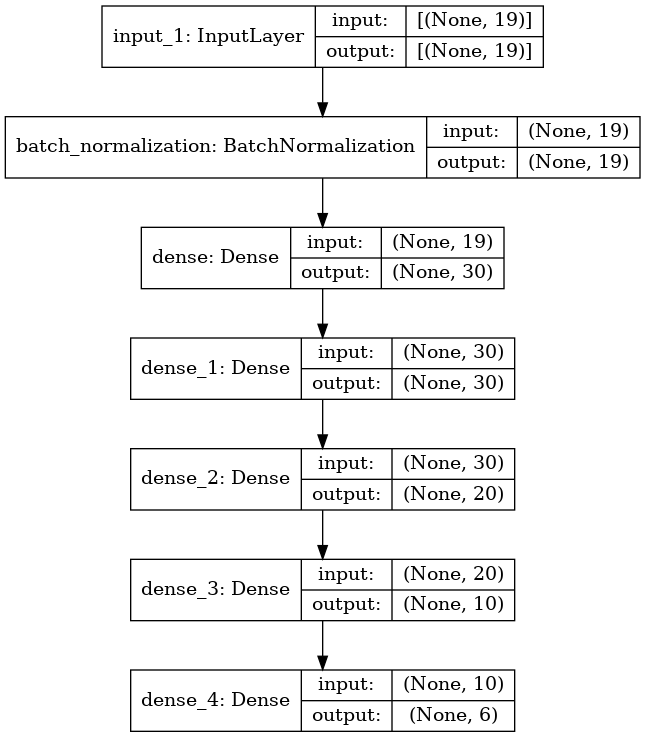

In [25]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Question / Exercise: see the number of free parameters in the dense networks. Can you explain them? You should (hint: remember the bias neuron!)

Now we need to train the network with the samples + their expected outputs. We should use [model.fit](https://www.tensorflow.org/guide/keras/train_and_evaluate) keras function, passing:
- the input feature numpy array 
- the output feature numpy array (the "truth")
- the number of epochs and the batchsize
- a partitioning between train and validation  (say 70% and 30%)

model.fit returns and history object we can use to see how the training process proceeded

In [26]:
history = model.fit(jetInfo, jetCategories, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_split=0.3)

Epoch 1/100
28/28 - 3s - loss: 1.6889 - val_loss: 1.5385
Epoch 2/100
28/28 - 0s - loss: 1.4605 - val_loss: 1.3113
Epoch 3/100
28/28 - 0s - loss: 1.2483 - val_loss: 1.2610
Epoch 4/100
28/28 - 0s - loss: 1.1408 - val_loss: 1.1519
Epoch 5/100
28/28 - 0s - loss: 1.1009 - val_loss: 1.1170
Epoch 6/100
28/28 - 0s - loss: 1.0839 - val_loss: 1.1011
Epoch 7/100
28/28 - 0s - loss: 1.0701 - val_loss: 1.0937
Epoch 8/100
28/28 - 0s - loss: 1.0649 - val_loss: 1.0897
Epoch 9/100
28/28 - 0s - loss: 1.0570 - val_loss: 1.0795
Epoch 10/100
28/28 - 0s - loss: 1.0502 - val_loss: 1.0800
Epoch 11/100
28/28 - 0s - loss: 1.0492 - val_loss: 1.0763
Epoch 12/100
28/28 - 0s - loss: 1.0452 - val_loss: 1.0721
Epoch 13/100
28/28 - 0s - loss: 1.0429 - val_loss: 1.0766
Epoch 14/100
28/28 - 0s - loss: 1.0414 - val_loss: 1.0715
Epoch 15/100
28/28 - 0s - loss: 1.0392 - val_loss: 1.0693
Epoch 16/100
28/28 - 0s - loss: 1.0391 - val_loss: 1.0686
Epoch 17/100
28/28 - 0s - loss: 1.0355 - val_loss: 1.0677
Epoch 18/100
28/28 - 0s

Did it work? was it enough? We need to see how the trainig went, on both training and validation samples. In order to do so, we can look into the "[history](https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/)" object. In particular, see **history.history['loss']** and **history.history['val_loss']** (which are the losses on train and validation). Plot them as a function of the epoch

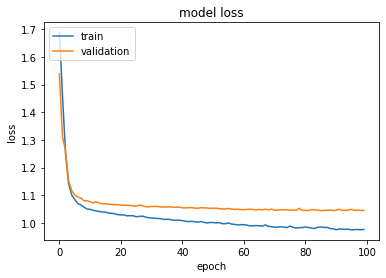

In [27]:
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Are you satified? Is the validation loss lower or higher than the training one? Is the model really improving after epoch (say) 50?

We should try and see if the algorithm (network) we prepared has good performance. The best way is to produce a ROC curve and see if it is better than the one we produced above. It should be, we used more input features!

The easiest way is to use the second file, containing other 20000 jets, to get an independet measurement. We reuse the code segment above.

In [28]:
import os
if not os.path.isfile('test93_20000_40000.npz'):
 !wget http://www.pi.infn.it/~boccali/test93_20000_40000.npz

URL transformed to HTTPS due to an HSTS policy
--2021-05-25 08:36:23--  https://www.pi.infn.it/~boccali/test93_20000_40000.npz
Resolving www.pi.infn.it (www.pi.infn.it)... 212.189.152.86
Connecting to www.pi.infn.it (www.pi.infn.it)|212.189.152.86|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41920506 (40M)
Saving to: ‘test93_20000_40000.npz’

test93_20000_40000. 100%[===================>]  39.98M  22.2MB/s    in 1.8s    

2021-05-25 08:36:25 (22.2 MB/s) - ‘test93_20000_40000.npz’ saved [41920506/41920506]



In [29]:
!ls -l test*

-rw-r--r-- 1 root root 41920506 Mar 30 13:51 test93_0_20000.npz
-rw-r--r-- 1 root root 41920506 Mar 30 13:51 test93_20000_40000.npz


Build analogous numpy vectors from the second test file

In [30]:
test=numpy.load("test93_20000_40000.npz")

testALL=test["arr_0"]

jetInfoTEST=testALL[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
jetCategoriesTEST=testALL[:,-9:-3]


Let's check the shapes are correct; do they make sense to you? (remember numpy arrays are [a,b) !!!)

In [31]:
print (jetInfoTEST.shape, jetCategoriesTEST.shape)

(20000, 19) (20000, 6)


Now we need to use the model.predict keras function, which produces an output of the same shape as the Monte Carlo truth we defined above; a direct comparison with the truth should be a good measure of how well we out ML system works!

In [32]:
predict_test = model.predict(jetInfoTEST)
print (predict_test.shape)

(20000, 6)


Let's print predict_test and jetCategriesTEST. What do you expect? Can you explain it?

In [33]:
print (predict_test)

[[2.06763856e-02 2.20307309e-04 1.49751483e-02 1.05312847e-01
  3.37029964e-01 5.21785319e-01]
 [2.70955618e-02 2.41200629e-04 2.05179974e-02 1.19416818e-01
  3.01532537e-01 5.31195879e-01]
 [7.26987515e-03 5.43116766e-04 6.61559869e-03 7.54404292e-02
  3.41246575e-01 5.68884432e-01]
 ...
 [7.06846476e-01 5.50698936e-02 1.87257320e-01 4.15861867e-02
  8.52605677e-04 8.38759635e-03]
 [1.53983906e-02 3.69001733e-04 1.03936065e-02 8.67402330e-02
  2.10078537e-01 6.77020252e-01]
 [4.86828953e-01 9.16425809e-02 1.76412091e-01 1.02454707e-01
  1.08113810e-02 1.31850302e-01]]


To be compared with the Monte Carlo truth

In [34]:
print (jetCategoriesTEST)

[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 ...
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]]


Let's build ROC curves. We had in the network 6 outpus (isB, isBB+isGBB, isLeptonicB+isLeptonicB_C, isC+isGCC+isCC, isUD+isS, isG), but in the ROC curves we just want B, C, light. We need to consolidate categories.
We can map

old 0,1,2 --> new 0 (B)

old 3 --> new 1 (C)

old 4 --> new 2 (light)

old 5 --> new 3 (gluon)

We do it for the Monte Carlo truth and for the output of the prediction. In practice, we sum the probabilities (assuming the various possibilities at least in MC truth have sum 1!)

In [81]:
# new roc tool
def plot_roc_curve(summed, predict_test_summed):
    # can you understand what this selection ">0" means?
    fpr, tpr, threshold = roc_curve(summed[:,0]>0,predict_test_summed[:,0])
    auc1 = auc(fpr, tpr)

    # B vs L/G roc curve

    summed_bl=summed[summed[:,1]==0]
    predict_test_bl=predict_test_summed[summed[:,1]==0]

    print (len(summed), len(summed_bl))

    fpr2, tpr2, threshold = roc_curve(summed_bl[:,0]>0,predict_test_bl[:,0])
    auc2 = auc(fpr2, tpr2)

    # B vs C roc curve

    summed_bc=summed[(summed[:,2]==0)*(summed[:,3]==0)]
    predict_test_bc=predict_test_summed[(summed[:,2]==0)*(summed[:,3]==0)]

    fpr3, tpr3, threshold = roc_curve(summed_bc[:,0]>0,predict_test_bc[:,0])
    auc3 = auc(fpr3, tpr3)

# Check AUC

    print ("AUCs", auc1, auc2, auc3)
    return tpr,fpr,tpr2,fpr2,tpr3,fpr3

In [86]:
summed=numpy.zeros((len(jetInfoTEST),4))

# Reducing it to 3 categories

summed[:,0]+=jetCategoriesTEST[:,0]
summed[:,0]+=jetCategoriesTEST[:,1]
summed[:,0]+=jetCategoriesTEST[:,2]
summed[:,1]+=jetCategoriesTEST[:,3]
summed[:,2]+=jetCategoriesTEST[:,4]
summed[:,3]+=jetCategoriesTEST[:,5]

predict_test_summed=numpy.zeros((len(jetInfoTEST),4))
predict_test_summed[:,0]+=predict_test[:,0]
predict_test_summed[:,0]+=predict_test[:,1]
predict_test_summed[:,0]+=predict_test[:,2]
predict_test_summed[:,1]+=predict_test[:,3]
predict_test_summed[:,2]+=predict_test[:,4]
predict_test_summed[:,3]+=predict_test[:,5]

print ("TEST sample prediction",summed[0:5,0])
print ("TEST sample truth     ",predict_test_summed[0:5,0])


TEST sample prediction [0. 0. 0. 0. 1.]
TEST sample truth      [0.08357219 0.09312621 0.03270689 0.11611616 0.48797216]


Do you understand these two lines above? what does 0/1 mean in the first line? Do you find a correspondence in the second line?

In [78]:
tpr,fpr,tpr2,fpr2,tpr3,fpr3 = plot_roc_curve(summed, predict_test_summed)


20000 17916
AUCs 0.9086648359467747 0.9226974686852336 0.8037096312949714


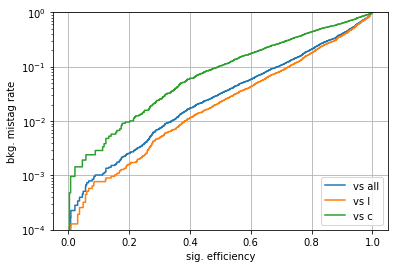

In [38]:
plt.plot(tpr,fpr,label="vs all")
plt.plot(tpr2,fpr2,label="vs l")
plt.plot(tpr3,fpr3,label="vs c")
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.0001,1)
plt.grid(True)
plt.legend(loc='lower right')

Is it better? Probably not really. Feature #11 we used before was already quite good. Can we do better?
you can try
- increasing the # of training epochs
- increasing the # of neurons in the dense layers

etc.

But we can also try something new: in the old training history, it seems we were reaching the plateau on the validation loss quite soon, while the training loss was still going down. This is a symptom of overtraining.

One standard trick to control this is via dropouts between dense layers. In this way, the network has more difficulties in precisely adapting to the training sample, and generally the performance on validation and orthogonal samples are better.

Going back to previous model definition, you can for example modify it including dropouts between the dense layers. [Dropout layers](https://keras.io/api/layers/regularization_layers/dropout/) have only one (important) parameter: the fraction of nodes being killed. 0.25 (25%) is a good starting point.



In [39]:
dropoutRate = 0.25

inputLayer = Input(shape=(19,))
x = BatchNormalization()(inputLayer)
####
x = Dense(30, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
####
x = Dense(30, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
####
x = Dense(20, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
####
x = Dense(10, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
####
outputLayer = Dense(6, activation='softmax')(x)
####
model = Model(inputs=inputLayer, outputs=outputLayer)

Re-evaluate the training losses, what do you see now? Did you expect this? if you go from 100 to 300 epochs, the difference should be even clearer

Epoch 1/100
28/28 - 1s - loss: 1.6518 - val_loss: 1.4208
Epoch 2/100
28/28 - 0s - loss: 1.4381 - val_loss: 1.2602
Epoch 3/100
28/28 - 0s - loss: 1.3565 - val_loss: 1.2133
Epoch 4/100
28/28 - 0s - loss: 1.3033 - val_loss: 1.1740
Epoch 5/100
28/28 - 0s - loss: 1.2724 - val_loss: 1.1616
Epoch 6/100
28/28 - 0s - loss: 1.2533 - val_loss: 1.1478
Epoch 7/100
28/28 - 0s - loss: 1.2381 - val_loss: 1.1422
Epoch 8/100
28/28 - 0s - loss: 1.2121 - val_loss: 1.1287
Epoch 9/100
28/28 - 0s - loss: 1.2059 - val_loss: 1.1255
Epoch 10/100
28/28 - 0s - loss: 1.1909 - val_loss: 1.1180
Epoch 11/100
28/28 - 0s - loss: 1.1777 - val_loss: 1.1140
Epoch 12/100
28/28 - 0s - loss: 1.1735 - val_loss: 1.1117
Epoch 13/100
28/28 - 0s - loss: 1.1719 - val_loss: 1.1071
Epoch 14/100
28/28 - 0s - loss: 1.1656 - val_loss: 1.1049
Epoch 15/100
28/28 - 0s - loss: 1.1601 - val_loss: 1.1017
Epoch 16/100
28/28 - 0s - loss: 1.1560 - val_loss: 1.1006
Epoch 17/100
28/28 - 0s - loss: 1.1521 - val_loss: 1.0982
Epoch 18/100
28/28 - 0s

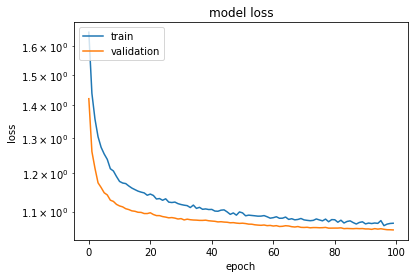

In [40]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
history = model.fit(jetInfo, jetCategories, epochs=n_epochs, batch_size=batch_size, verbose = 2, validation_split=0.3)
from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Do you see a difference? Is that expected? 

Do you see that the train and validation curves are in the same order? If not, do you have an idea why?

And, is the final performance better (as per the ROC curve)?

20000 17916
0.8728994889876773 0.8857999847557125 0.776411951782128


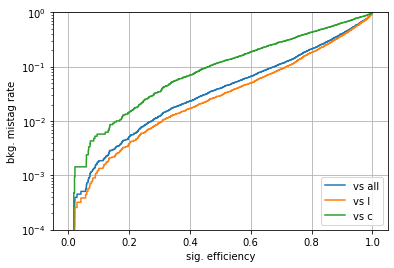

In [41]:
predict_test = model.predict(jetInfoTEST)
summed=numpy.zeros((len(jetInfoTEST),4))
summed[:,0]+=jetCategoriesTEST[:,0]
summed[:,0]+=jetCategoriesTEST[:,1]
summed[:,0]+=jetCategoriesTEST[:,2]
summed[:,1]+=jetCategoriesTEST[:,3]
summed[:,2]+=jetCategoriesTEST[:,4]
summed[:,3]+=jetCategoriesTEST[:,5]

# Reducing it to 3 categories

predict_test_summed=numpy.zeros((len(jetInfoTEST),4))
predict_test_summed[:,0]+=predict_test[:,0]
predict_test_summed[:,0]+=predict_test[:,1]
predict_test_summed[:,0]+=predict_test[:,2]
predict_test_summed[:,1]+=predict_test[:,3]
predict_test_summed[:,2]+=predict_test[:,4]
predict_test_summed[:,3]+=predict_test[:,5]

tpr,fpr,tpr2,fpr2,tpr3,fpr3 = plot_roc_curve(summed, predict_test_summed)

plt.plot(tpr,fpr,label="vs all")
plt.plot(tpr2,fpr2,label="vs l")
plt.plot(tpr3,fpr3,label="vs c")
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.0001,1)
plt.grid(True)
plt.legend(loc='lower right')

At this point, if you reached here, play a bit with the possible configurations (epochs, number and population of dense layers, ...).

A consideration: b quark selection tools are useful in both regimes of  

- high B efficiency with moderate light efficiency
- lower B efficiency with very small light efficiency

Other things you may want to try:

- you can increase at will the number of epochs, but at some point the gain will become minimal, so all the iterations from there on are "wasted time". You can put in the model.fit options to terminate the training at some point, or to try a finer approach to a minimum, for example try adding some callbacks

                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)]

ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving.
    factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
    patience: number of epochs with no improvement after which learning rate will be reduced.


EarlyStopping: Stop training when a monitored metric has stopped improving.
    patience	Number of epochs with no improvement after which training will be stopped. This has an important effect: you can increase the # of epochs, but it can have 0 effects if you have an early stop. In that case you need to increase the network complexity / reduce the stopping sensitivity in order to perform more training.
    
TerminateOnNaN: Stop if you find a NaN
    

### try them!

yon will need to


In [42]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

By the way.... Clearly this is a small network, on a small dataset. If we want to go higher, we'd better be faster, which means use a GPU.
If we used a VM with GPU and instantiated a container with GPU, we are probably already doing this. Let's check!

In [43]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13136541995031458341
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14648653952
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6088930729082924496
physical_device_desc: "device: 0, name: NVIDIA Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5"
]


# If you are really here ... a possible second part. Note that you are NOT expected to do all during the hackathon time; you can also have a look later

In the previous example, only "jet level features" were used (Pt, #of tracks, ...).
If we have them avaiable, we could use also the characteristic of each track. But this makes a huge input (210 added features per jet), so potentially more than 4x what is already there. The dense layers will then see an exploding number of weights (it can be ok, depending on the ghardware you have)

One possible solution is via Long Short Term Memories: recurrent neurons which "remember last state" and hence can accept asequence of inputs belonging to the same test case. They are typical in speech recognition, where a sentence is composed of a not standard number of words; as in sentences, there is a "stop signal" saying that the inputs are over.

What we are going to try here is to complement the DNN we prepared with tracking information each track belonging to a jet.
In order to do so, we look into an additional numpy array in the input: arr_1.
it has a shape

In [44]:
f["arr_1"].shape

(20000, 10, 21)

So it contains 20000 jets, for each of them a 2d entry. They should be read as 21 parameters per track for a max of 10 tracks per jet. Let's look into it

In [45]:
f["arr_1"][0,:,0]

array([0.67382812, 0.63623047, 5.11328125, 4.51953125, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

This was plottong the first (0) of the 21 features for each track of the first jet. The zeros means there were not 10 tracks in the jet, but just 4.

The 21 features are 
# kinematics

0. seed_pt : the track pt
1. seed_eta : the track eta
2. seed_phi : the track phi
3. seed_mass : the track mass (usually a pion mass, but if some particle id happened, could be a lepton for example)

# impact parameters

4. seed_dz : distance of closest apprach to the beamline in z
5. seed_dxy : 2-d distance of closest apprach to the beamline in (x,y) - the transverse plane
6. seed_3D_ip : the track Impact Parameter (see forexample slide 4 in https://indico.cern.ch/event/322015/contributions/746885/attachments/622358/856332/B-tagging2.pdf )
7. seed_3D_sip : the significance (value/error) of the IP
8. seed_2D_ip : as above but only in (x,y)
9. seed_2D_sip : as above but only in (x,y)
10. seed_3D_signedIp
11. seed_3D_signedSip
12. seed_2D_signedIp
13. seed_2D_signedSip

# track probability (from IP) 

14. seed_3D_TrackProbability : the probability of this track to come from the primary vertex, in 3D
15. seed_2D_TrackProbability : the probability of this track to come from the primary vertex, in 2D

# quality 

16. seed_chi2reduced : the chi2 of the track fit
17. seed_nPixelHits : the number of hits in the CMS pixel system
18. seed_nHits : total number of hits in the track

# jet-track distance

19. seed_jetAxisDistance : the minimum distance (in 3D) between the track and the jet axis
20. seed_jetAxisDlength : the decay length (distance between the primary vertex and the point of closest apprach between the track and the jet axis)

So they contain quantities which are well correlated with b tagging, like IP (Impact parameter) size, error and probability. This should help us in getting a better algorithm!

We need to define the inputs. They are now the standard 19 features as before (or any number you decided to use) + the (10,21) bidimensional input, that we want to treat via an LSTM input. The input to the DNN will be the 19 features + the output of LSTM, for which we can define the dimensionality (64 here)

Let's start as before by defining parameters

In [46]:
dataTRACKS=f["arr_1"]
batch_size = 512
n_epochs = 100
dropoutRate = 0.25

In [47]:
from keras.layers import LSTM

input1=[Input(shape=(19,))]
input2=[Input(shape=(10,21))]


Inputs = input1
Inputs+=input2

print (input2)


[<KerasTensor: shape=(None, 10, 21) dtype=float32 (created by layer 'input_4')>]


the second input, tracks, is seen by the rest of the network as a simple additional 64 inputs to the 19

In [48]:
print (input2[0].shape)

(None, 10, 21)


In [49]:


tracks  = LSTM(64)(input2)


The last flatten prepares a numpy array like structure, usable for input to the DNN. Which is the size you expect it to have?

In [50]:
print (tracks.shape)

(None, 64)


We can append these 64 features to the previous 19 (19+64 = 83)

In [51]:
x = Concatenate()( [Inputs[0] , tracks] )
print (x.shape)

(None, 83)


From this point on, we define a "normal" DNN (this time we can do directly with dropouts, as said before) ... 

In [52]:
x=  Dense(200, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)

predictions = Dense(6, activation='softmax')(x)
model = Model(inputs=Inputs, outputs=predictions)


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10, 21)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 64)           22016       input_4[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 83)           0           input_3[0][0]                    
                                                                 lstm[0][0]                 

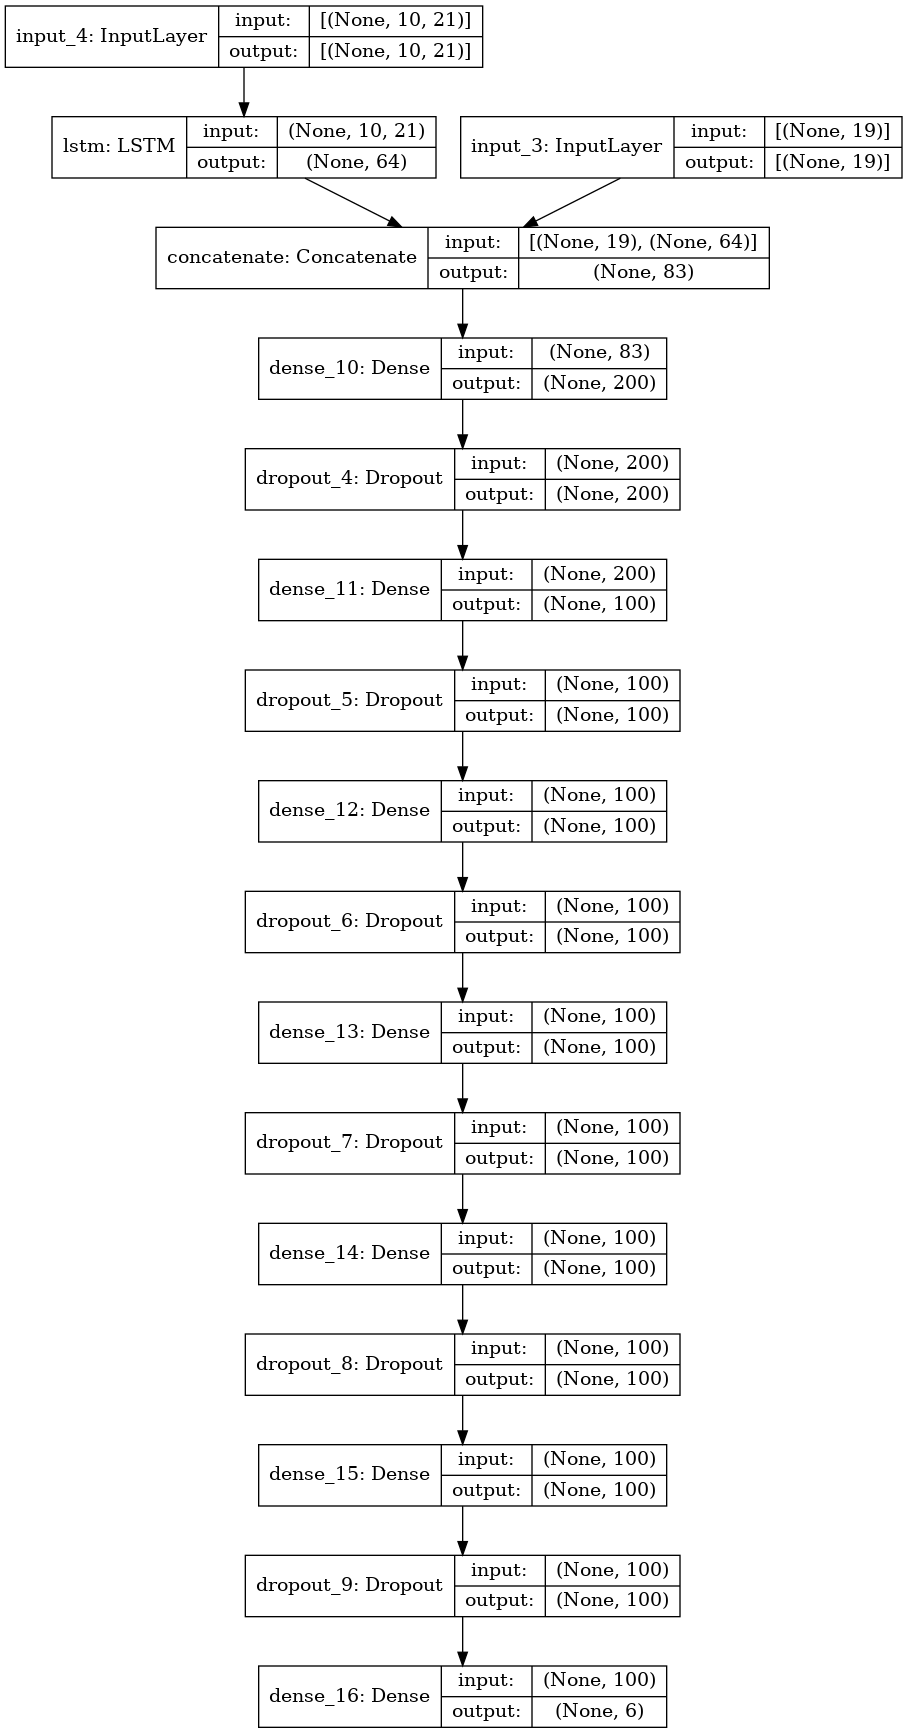

In [53]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Again, can you make sense to the numbers you see?

In [54]:
history = model.fit([jetInfo, dataTRACKS], jetCategories, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_split=0.3,
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=30, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/100
28/28 - 8s - loss: 2.6334 - val_loss: 1.5460
Epoch 2/100
28/28 - 0s - loss: 1.5245 - val_loss: 1.3103
Epoch 3/100
28/28 - 0s - loss: 1.4165 - val_loss: 1.2437
Epoch 4/100
28/28 - 0s - loss: 1.3087 - val_loss: 1.2132
Epoch 5/100
28/28 - 0s - loss: 1.2563 - val_loss: 1.1832
Epoch 6/100
28/28 - 0s - loss: 1.2141 - val_loss: 1.1411
Epoch 7/100
28/28 - 0s - loss: 1.1887 - val_loss: 1.1264
Epoch 8/100
28/28 - 1s - loss: 1.1754 - val_loss: 1.1408
Epoch 9/100
28/28 - 0s - loss: 1.1505 - val_loss: 1.1353

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 10/100
28/28 - 0s - loss: 1.1368 - val_loss: 1.1433
Epoch 11/100
28/28 - 0s - loss: 1.1355 - val_loss: 1.1365

Epoch 00011: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 12/100
28/28 - 0s - loss: 1.1343 - val_loss: 1.1386
Epoch 13/100
28/28 - 0s - loss: 1.1399 - val_loss: 1.1402

Epoch 00013: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Epoch 14/

Did it work? Let's see the performance. First of all the usual loss wrt epochs.

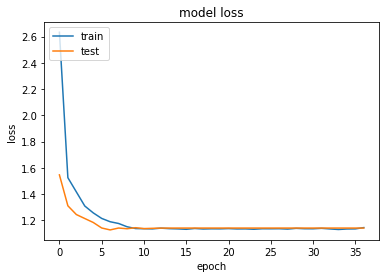

In [55]:
# plot training history

from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('linear')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now we repeat the test with the ROC using the second file

In [56]:
testALL=test["arr_0"]

jetInfoTEST=testALL[:,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]]
print (jetInfoTEST.shape)
jetCategoriesTEST=testALL[:,-9:-3]
dataTrackTEST=test["arr_1"]

predict_test = model.predict([jetInfoTEST,dataTrackTEST] )
print(predict_test.shape)

(20000, 19)
(20000, 6)


In [57]:
predict_test = model.predict([jetInfoTEST,dataTrackTEST] )


In [58]:
print(predict_test.shape)

(20000, 6)


The next line should not be neededm but I saw that in some cases the predict_test contained a NaN (not a Number, a floating point error). The next line just wipes the NaN entries

In [59]:
predict_test[numpy.where(numpy.isnan(predict_test))]=0.

In [60]:
# Reducing it to 4 categories

summed=numpy.zeros((len(jetInfoTEST),4))
summed[:,0]+=jetCategoriesTEST[:,0]
summed[:,0]+=jetCategoriesTEST[:,1]
summed[:,0]+=jetCategoriesTEST[:,2]
summed[:,1]+=jetCategoriesTEST[:,3]
summed[:,2]+=jetCategoriesTEST[:,4]
summed[:,3]+=jetCategoriesTEST[:,5]

# Reducing it to 4 categories

predict_test_summed=numpy.zeros((len(jetInfoTEST),4))
predict_test_summed[:,0]+=predict_test[:,0]
predict_test_summed[:,0]+=predict_test[:,1]
predict_test_summed[:,0]+=predict_test[:,2]
predict_test_summed[:,1]+=predict_test[:,3]
predict_test_summed[:,2]+=predict_test[:,4]
predict_test_summed[:,3]+=predict_test[:,5]

In [61]:
tpr,fpr,tpr2,fpr2,tpr3,fpr3 = plot_roc_curve(summed, predict_test_summed)


20000 17916
0.8987330059931588 0.9125621661300636 0.7952996475219815


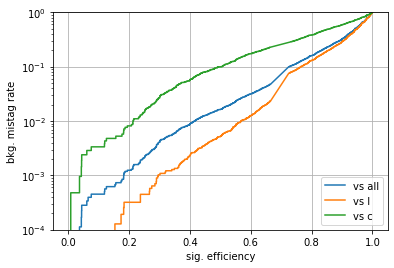

In [62]:
# SEMILOG

plt.plot(tpr,fpr,label="vs all")
plt.plot(tpr2,fpr2,label="vs l")
plt.plot(tpr3,fpr3,label="vs c")
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.0001,1)
plt.grid(True)
plt.legend(loc='lower right')


Good work! if you reached here, you have implemented a working (altough with limited performance, due to the needs to be interactive) LSTM algorithm.
As usual, you can try tweaking the model, layers, epochs etc to see if you can optimize it in different regions of the B efficiency spectrum

# You are here??? Very very good .... Let's try something different then. Substituting the LSTM with a Convolutional Network 1D

We still have the same problem: adding 10x21 additional features to out 19 standard ones, without blowing up the network size.
In the previous use case, we used LSTM to reduce the tacking part from 210 to 64 features; here we want to use a different way: a 1d convolutional network to preprocess the 210 features and form a smaller set to be fed to the DNN.

Convolutiola networks read multidimensional matrices (10x21 in this case) and interpret them as "images". On them , standard convolutional methods are processed; being 1d, the convolutional "window" goes only in one direction, thus again matching the natural flow, for example, of time series or speech.

We will apply a series of Conv1D filters, each one lowering the output dimesion of the previous one. In the end, we want to have a dimensionality of 4 (for example), which means that from 10 tracks we get 40 features instead of 210.

We mostly reuse the numpy arrays from LSTM

In [63]:
from keras.layers import Conv1D

batch_size = 512
n_epochs = 100
dropoutRate = 0.25

We define 4 Convolutional layers, with output dimension 64, 32, 8, 4. 

In [64]:
tracks=Inputs[1]

tracks  = Conv1D(64, 1, activation='relu')(tracks)
tracks = Dropout(rate=dropoutRate)(tracks)
tracks  = Conv1D(32, 1, activation='relu')(tracks)
tracks = Dropout(rate=dropoutRate)(tracks)
tracks  = Conv1D(8, 1,  activation='relu')(tracks)
tracks = Dropout(rate=dropoutRate)(tracks)
tracks  = Conv1D(4, 1,   activation='relu')(tracks)
        


can you guess what tracks is? (which shape)

In [65]:
print (tracks.shape)

(None, 10, 4)


If we want to use this as input to a DNN, we do not want a 10x4 matrix, but a single dimensional numpy array of size 40. We need to Flatten!

In [66]:
tracks = Flatten()(tracks)
print (tracks.shape)

(None, 40)


Now we can add the usual DNN part

In [67]:
x = Concatenate()( [Inputs[0] , tracks] )


x=  Dense(200, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
x=  Dense(100, activation='relu')(x)
x = Dropout(rate=dropoutRate)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=Inputs, outputs=predictions)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 10, 21)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 10, 64)       1408        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_10 (Dropout)            (None, 10, 64)       0           conv1d[0][0]                     
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 10, 32)       2080        dropout_10[0][0]                 
____________________________________________________________________________________________

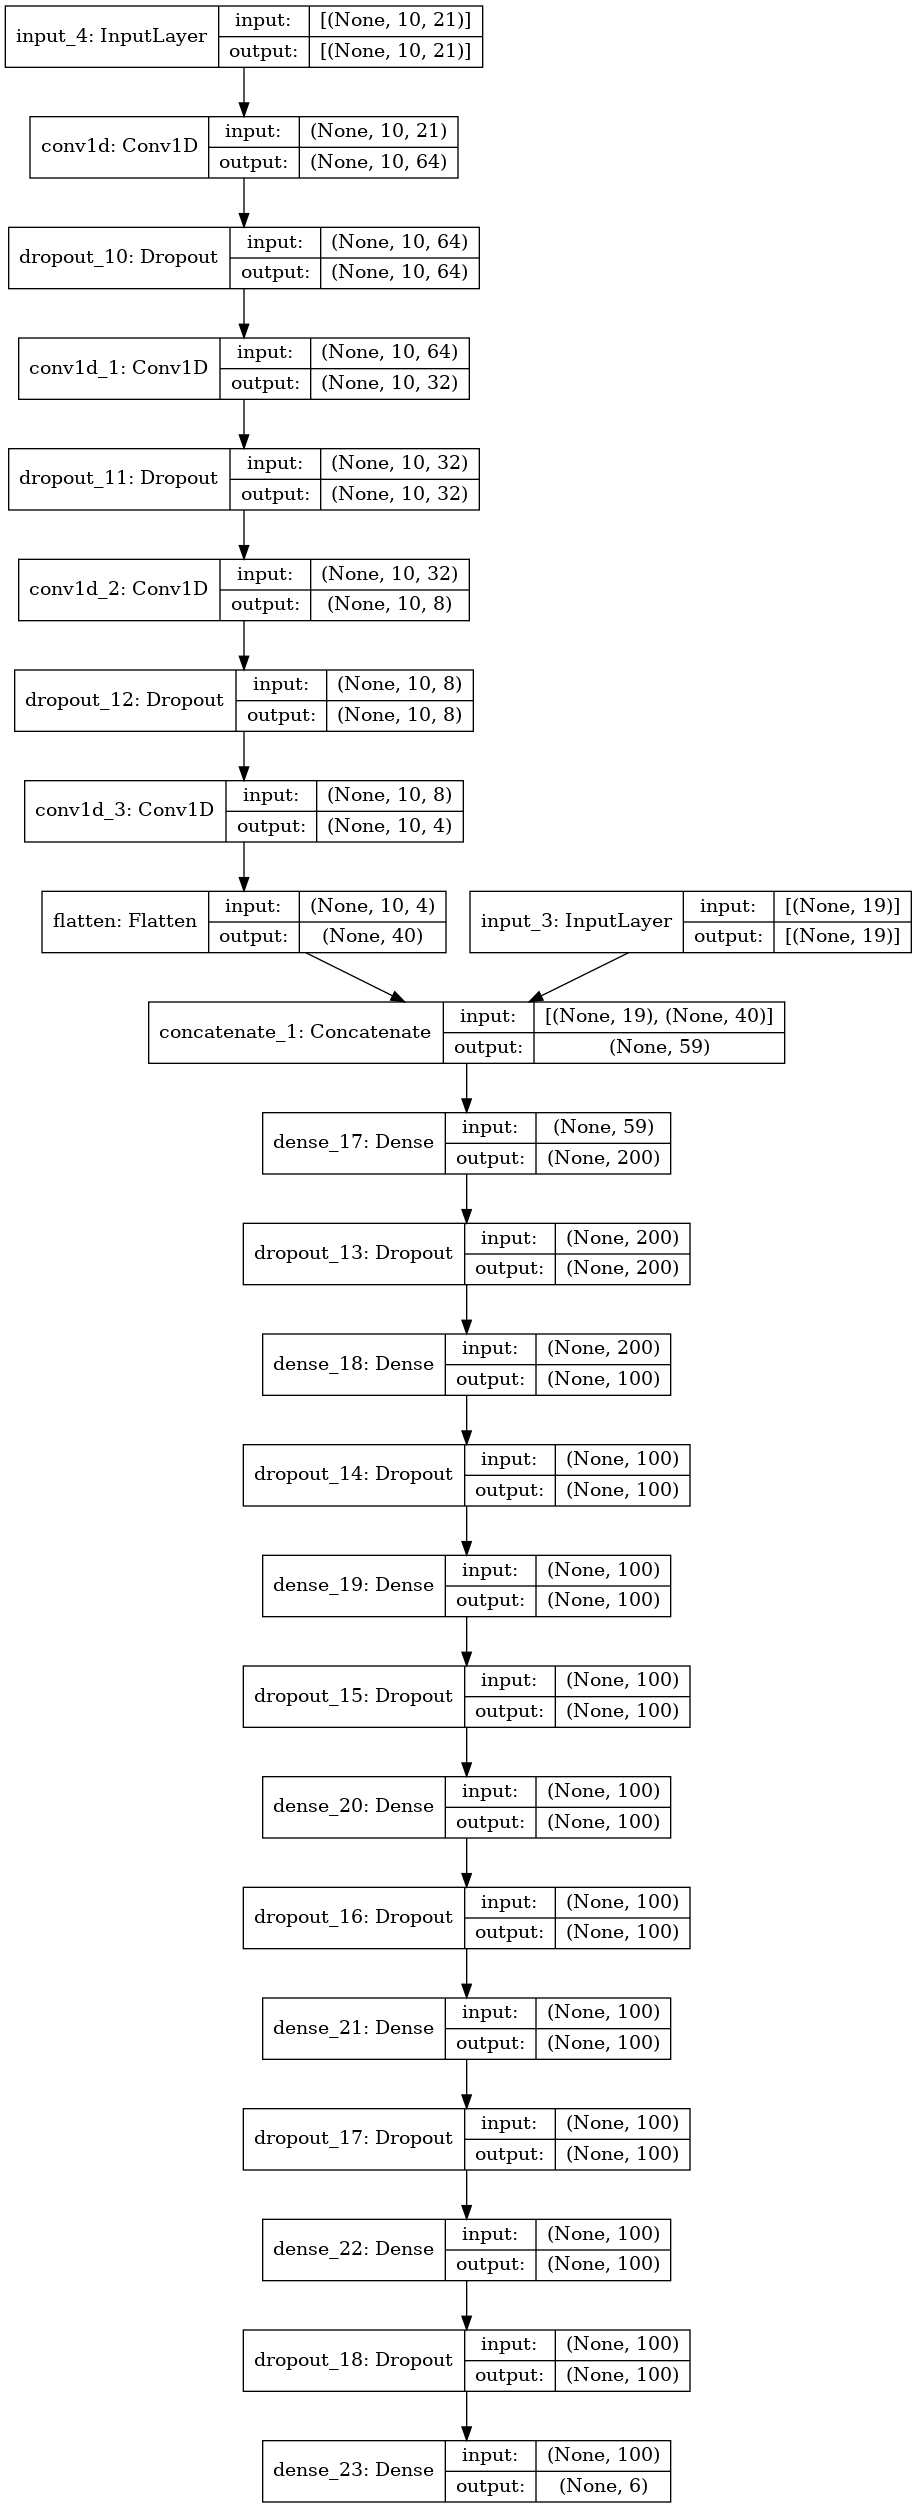

In [76]:
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


Can you explain / predict the number of free parameters per layer?

Let's train it

In [69]:
history = model.fit([jetInfo, dataTRACKS], jetCategories, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_split=0.3,
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/100
28/28 - 3s - loss: 3.2130 - val_loss: 1.6088
Epoch 2/100
28/28 - 0s - loss: 1.5535 - val_loss: 1.4401
Epoch 3/100
28/28 - 0s - loss: 1.4483 - val_loss: 1.3688
Epoch 4/100
28/28 - 0s - loss: 1.3943 - val_loss: 1.3071
Epoch 5/100
28/28 - 1s - loss: 1.3372 - val_loss: 1.2572
Epoch 6/100
28/28 - 0s - loss: 1.3061 - val_loss: 1.2366
Epoch 7/100
28/28 - 0s - loss: 1.2671 - val_loss: 1.2088
Epoch 8/100
28/28 - 0s - loss: 1.2398 - val_loss: 1.1860
Epoch 9/100
28/28 - 0s - loss: 1.2183 - val_loss: 1.2005
Epoch 10/100
28/28 - 1s - loss: 1.2064 - val_loss: 1.1732
Epoch 11/100
28/28 - 0s - loss: 1.1903 - val_loss: 1.1626
Epoch 12/100
28/28 - 0s - loss: 1.1750 - val_loss: 1.1539
Epoch 13/100
28/28 - 0s - loss: 1.1713 - val_loss: 1.1492
Epoch 14/100
28/28 - 1s - loss: 1.1615 - val_loss: 1.1330
Epoch 15/100
28/28 - 0s - loss: 1.1465 - val_loss: 1.1377
Epoch 16/100
28/28 - 0s - loss: 1.1290 - val_loss: 1.1149
Epoch 17/100
28/28 - 0s - loss: 1.1222 - val_loss: 1.1179
Epoch 18/100
28/28 - 1s

Did it work? Let's see the losses as function of the epochs

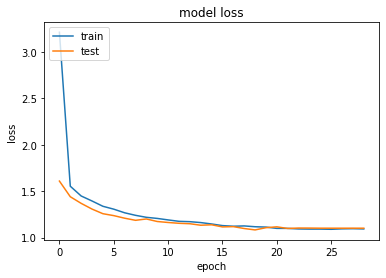

In [70]:
# plot training history

from matplotlib import pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('linear')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Try the usual ROC Curve

In [71]:
predict_test = model.predict([jetInfoTEST,dataTrackTEST] )
print(predict_test.shape)

(20000, 6)


usual problem with the NaNs (no comment...)

In [72]:
predict_test[numpy.where(numpy.isnan(predict_test))]=0.

In [73]:
# Reducing it to 4 categories

summed=numpy.zeros((len(jetInfoTEST),4))
summed[:,0]+=jetCategoriesTEST[:,0]
summed[:,0]+=jetCategoriesTEST[:,1]
summed[:,0]+=jetCategoriesTEST[:,2]
summed[:,1]+=jetCategoriesTEST[:,3]
summed[:,2]+=jetCategoriesTEST[:,4]
summed[:,3]+=jetCategoriesTEST[:,5]

# Reducing it to 4 categories

predict_test_summed=numpy.zeros((len(jetInfoTEST),4))
predict_test_summed[:,0]+=predict_test[:,0]
predict_test_summed[:,0]+=predict_test[:,1]
predict_test_summed[:,0]+=predict_test[:,2]
predict_test_summed[:,1]+=predict_test[:,3]
predict_test_summed[:,2]+=predict_test[:,4]
predict_test_summed[:,3]+=predict_test[:,5]

In [74]:
tpr,fpr,tpr2,fpr2,tpr3,fpr3 = plot_roc_curve(summed, predict_test_summed)


20000 17916
0.9086648359467747 0.9226974686852336 0.8037096312949714


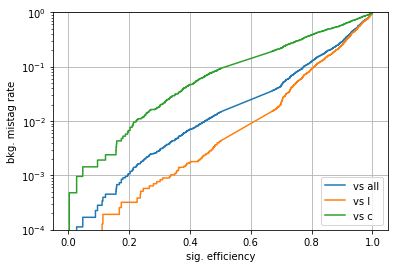

In [75]:
# SEMILOG

plt.plot(tpr,fpr,label="vs all")
plt.plot(tpr2,fpr2,label="vs l")
plt.plot(tpr3,fpr3,label="vs c")
plt.semilogy()
plt.xlabel("sig. efficiency")
plt.ylabel("bkg. mistag rate")
plt.ylim(0.0001,1)
plt.grid(True)
plt.legend(loc='lower right')

# Play with all the parameters, etc, and ...

# Which is the absolute best result you can get?

#  ....That's all folks!